---
author: Zeel B Patel
badges: true
categories: ML
description: Bayesian Basis Regression
title: Bayesian Basis Regression
date: '2023-08-31'
toc: true
---

In [8]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import pandas as pd
import regdata as rd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

from tqdm import tqdm

import matplotlib.pyplot as plt

device = "cuda"
rd.set_backend("torch")


## Generate data

torch.Size([94, 2]) torch.Size([94])
torch.float32 torch.float32


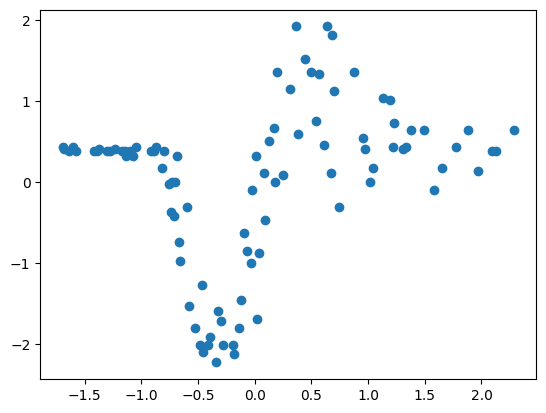

In [9]:
# x = torch.linspace(-1, 1, 100)
# y = (torch.sin(x * 2 * torch.pi) + torch.randn(x.size()) * 0.1).unsqueeze(1)
x, y, _ = rd.MotorcycleHelmet().get_data()
x = x.ravel().to(torch.float32)
idx = np.argsort(x)
x = x[idx]
y = y.to(torch.float32)
y = y[idx]

x = torch.vstack([torch.ones_like(x), x]).T
print(x.shape, y.shape)
x = x.to(device)
y = y.to(device)
print(x.dtype, y.dtype)

plt.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())


In [10]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, neurons, transform=None):
        super().__init__()
        self.layers = nn.ModuleList()
        self.transform = transform
        if transform is None:
            self.transform = lambda x: x
            self.layers.append(nn.Linear(in_dim, neurons[0]))
        else:
            self.layers.append(nn.Linear(self.transform.n_grid + 1, neurons[0]))
        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))
        self.layers.append(nn.Linear(neurons[-1], out_dim))

    def forward(self, x):
        x = self.transform(x)
        # print(x.shape)
        for layer in self.layers[:-1]:
            x = F.gelu(layer(x))
        return self.layers[-1](x)


class RBF(nn.Module):
    def __init__(self, log_gauss_var, n_grid):
        super().__init__()
        self.log_gauss_var = nn.Parameter(torch.tensor(log_gauss_var))
        self.n_grid = n_grid
        self.grid = nn.Parameter(torch.linspace(-1, 1, n_grid))
        self.register_buffer("bias", torch.zeros(1))

    def forward(self, x):
        self.dist = dist.Normal(self.grid, torch.exp(self.log_gauss_var))
        features = torch.exp(self.dist.log_prob(x[:, 1:2]))
        # print(features.shape)
        features = torch.cat(
            [
                torch.ones_like(self.bias.repeat(features.shape[0])).reshape(-1, 1),
                features,
            ],
            dim=1,
        )
        return features


In [11]:
RBF(0.0, 10).to(device)(x).shape

torch.Size([94, 11])

In [12]:
# def transform_fn(x):
#     all_x = []
#     for i in range(2, 11):
#         all_x.append(x[:, 1:2] ** i)
#     return torch.hstack([x] + all_x)


def get_mn_sn(x, s0):
    x = transform_fn(x)
    sn_inv = (x.T @ x) / torch.exp(log_var_noise)
    diag = sn_inv.diagonal()
    diag += 1 / s0
    sn = torch.inverse(sn_inv)
    mn = sn @ ((x.T @ y) / torch.exp(log_var_noise))
    return mn, sn


def neg_log_likelihood(x, y, m0, s0):
    x = transform_fn(x)
    cov = (x @ x.T) / s0
    diag = cov.diagonal()
    diag += torch.exp(log_var_noise)
    return (
        -dist.MultivariateNormal(m0.repeat(y.shape[0]), cov).log_prob(y.ravel()).sum()
    )


def get_pred_post(sn, mn, x):
    x = transform_fn(x)
    pred_cov = x @ sn @ x.T
    diag = pred_cov.diagonal()
    diag += torch.exp(log_var_noise)
    pred_mean = x @ mn
    return pred_mean, pred_cov


def plot_preds_and_95(ax, x, pred_mean, pred_cov):
    with torch.no_grad():
        x = x[:, 1].cpu().numpy()
        pred_mean = pred_mean.ravel().cpu().numpy()
        pred_var = pred_cov.diagonal().cpu().numpy()
        ax.plot(x, pred_mean, color="red", label="mean")
        ax.fill_between(
            x,
            (pred_mean - 2 * np.sqrt(pred_var)),
            (pred_mean + 2 * np.sqrt(pred_var)),
            color="red",
            alpha=0.2,
            label="95% CI",
        )
        return ax

In [33]:
mlp = MLP(2, 1, [256, 256, 256]).to(device)
# mlp = RBF(0.1, 20).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = True
    s0.requires_grad = True


loss: 30.6285: 100%|██████████| 500/500 [00:02<00:00, 209.49it/s]


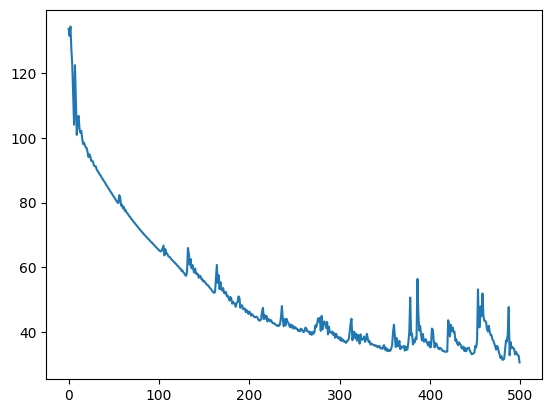

In [34]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.01)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

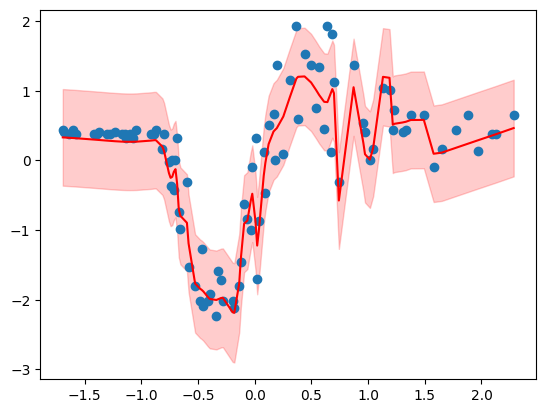

In [35]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    # ax.vlines(mlp.transform.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()

In [23]:
torch.exp(log_var_noise), s0, m0

(tensor(0.1191, device='cuda:0', grad_fn=<ExpBackward0>),
 tensor(1.3897, device='cuda:0', requires_grad=True),
 tensor([-0.0693], device='cuda:0', requires_grad=True))

## Add Gaussian transform

In [104]:
mlp = MLP(2, 1, [256, 256, 256], transform=RBF(0.1, 10)).to(device)
# mlp = RBF(0.1, 20).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = False
    s0.requires_grad = True


loss: -29.9227: 100%|██████████| 500/500 [00:03<00:00, 156.90it/s]


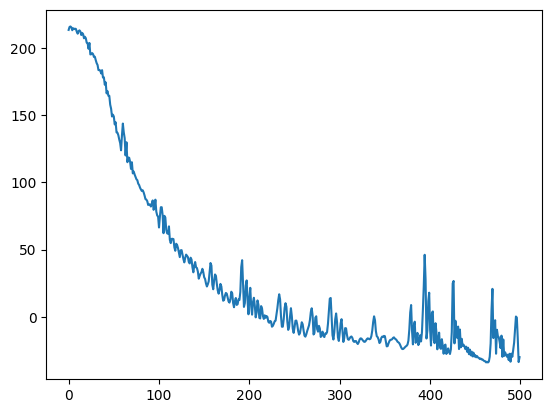

In [105]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.01)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

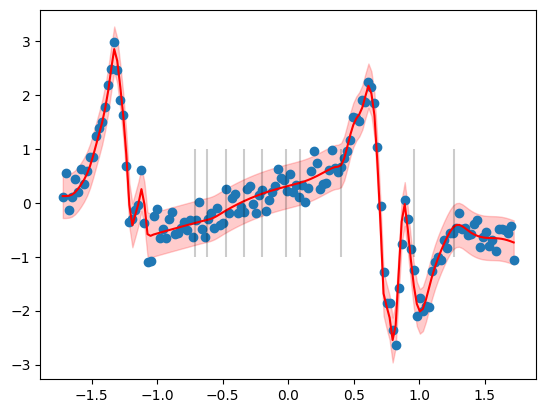

In [106]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    ax.vlines(mlp.transform.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()


## Just Gaussian basis

In [107]:
# mlp = MLP(2, 1, [32, 32, 32], transform=RBF(0.1, 10)).to(device)
mlp = RBF(1.0, 5).to(device)
transform_fn = mlp.forward

m0 = torch.zeros((1,)).to(device)
s0 = torch.tensor(1.0).to(device)
with torch.no_grad():
    log_var_noise = nn.Parameter(torch.tensor(0.1)).to(device)
    log_var_noise.requires_grad = True
    m0.requires_grad = False
    s0.requires_grad = True


loss: 207.0843: 100%|██████████| 500/500 [00:02<00:00, 195.61it/s]


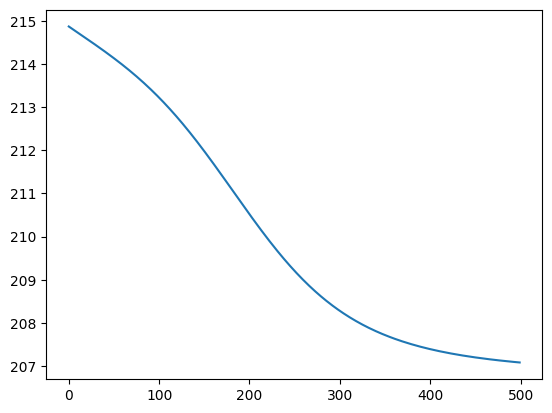

In [108]:
optimizer = torch.optim.Adam([*list(mlp.parameters()), log_var_noise, m0, s0], lr=0.001)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = neg_log_likelihood(x, y, m0, s0)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

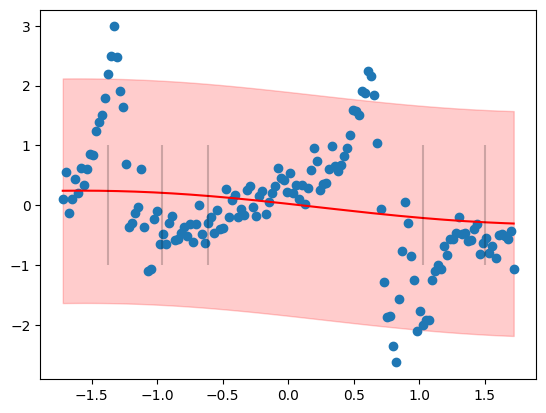

In [109]:
mn, sn = get_mn_sn(x, s0)
pred_mean, pred_var = get_pred_post(sn, mn, x)

fig, ax = plt.subplots()
ax = plot_preds_and_95(ax, x, pred_mean, pred_var)
with torch.no_grad():
    ax.scatter(x.cpu().numpy()[:, 1], y.cpu().numpy())
    ax.vlines(mlp.grid.cpu().numpy(), -1, 1, color="black", alpha=0.2)
plt.show()


## Appendix

In [185]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [186]:
data = pd.read_csv("~/datasets/uci/bike/hour.csv", header=None).iloc[:, 1:]
data.shape

(17379, 18)

In [187]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

x_scaler = MinMaxScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((10427, 17), (6952, 17), (10427, 1), (6952, 1))

In [188]:
[X_train, X_test, y_train, y_test] = map(
    lambda x: torch.tensor(x, dtype=torch.float32).to(device),
    [X_train, X_test, y_train, y_test],
)


loss: 0.0040: 100%|██████████| 500/500 [00:01<00:00, 482.25it/s]


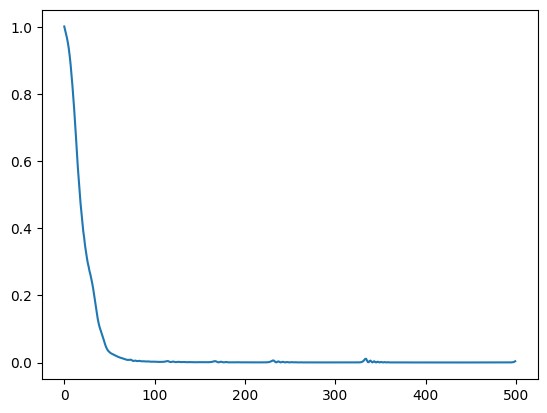

In [189]:
mlp = MLP(17, 1, [10, 10]).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
losses = []
pbar = tqdm(range(500))
for i in pbar:
    optimizer.zero_grad()
    loss = F.mse_loss(mlp(X_train), y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)


In [190]:
with torch.no_grad():
    y_pred = mlp(X_test).cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    print(y_pred.shape, y_test.shape)
    print("RMSE", mean_squared_error(y_test, y_pred, squared=False))

(6952, 1) (6952, 1)
RMSE 0.08354535
